In [1]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
%matplotlib inline
#algunas opciones para Pandas
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [7]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

## Valuación usando simulación: modelo normal para los rendimientos

In [3]:
aapl = web.YahooOptions('AAPL')
aapl_opt = aapl.get_all_data().reset_index()
aapl_opt.set_index('Expiry').sort_index()

,Strike,Type,Symbol,...,Quote_Time,Last_Trade_Date,JSON
Expiry,,,,,,,
2019-11-22,262.5,call,AAPL191122C00262500,...,2019-11-21 19:34:10,2019-11-21 19:18:20,"{'contractSymbol': 'AAPL191122C00262500', 'str..."
2019-11-22,290.0,put,AAPL191122P00290000,...,2019-11-21 19:34:10,2019-11-08 20:46:18,"{'contractSymbol': 'AAPL191122P00290000', 'str..."
2019-11-22,175.0,put,AAPL191122P00175000,...,2019-11-21 19:34:10,2019-11-08 18:17:22,"{'contractSymbol': 'AAPL191122P00175000', 'str..."
2019-11-22,175.0,call,AAPL191122C00175000,...,2019-11-21 19:34:10,2019-11-11 17:40:28,"{'contractSymbol': 'AAPL191122C00175000', 'str..."
2019-11-22,232.5,put,AAPL191122P00232500,...,2019-11-21 19:34:10,2019-11-21 17:47:27,"{'contractSymbol': 'AAPL191122P00232500', 'str..."
...,...,...,...,...,...,...,...
2022-01-21,185.0,call,AAPL220121C00185000,...,2019-11-21 19:34:18,2019-11-20 17:08:35,"{'contractSymbol': 'AAPL220121C00185000', 'str..."
2022-01-21,185.0,put,AAPL220121P00185000,...,2019-11-21 19:34:18,2019-11-20 20:58:12,"{'contractSymbol': 'AAPL220121P00185000', 'str..."
2022-01-21,235.0,put,AAPL220121P00235000,...,2019-11-21 19:34:18,2019-11-20 16:33:23,"{'contractSymbol': 'AAPL220121P00235000', 'str..."


In [4]:
indice_opt = aapl_opt.loc[(aapl_opt.Type=='put') & (aapl_opt.Strike==240) & (aapl_opt.Expiry=='2021-01-15')]
indice_opt

,Strike,Expiry,Type,...,Quote_Time,Last_Trade_Date,JSON
853,240.0,2021-01-15,put,...,2019-11-21 19:34:18,2019-11-21 16:59:19,"{'contractSymbol': 'AAPL210115P00240000', 'str..."


In [5]:
i_opt= indice_opt.index
opcion_valuar = aapl_opt.loc[i_opt[0]]
opcion_valuar['JSON']

{'contractSymbol': 'AAPL210115P00240000',
 'strike': 240.0,
 'currency': 'USD',
 'lastPrice': 18.6,
 'change': 0.11000061,
 'percentChange': 0.5949195,
 'volume': 23,
 'openInterest': 1539,
 'bid': 18.25,
 'ask': 18.55,
 'contractSize': 'REGULAR',
 'expiration': 1610668800,
 'lastTradeDate': 1574355559,
 'impliedVolatility': 0.26428958374023437,
 'inTheMoney': False}

# Simulación de precios usando rendimiento simple y logarítmico 

* Comenzaremos por suponer que los rendimientos son un p.e. estacionario que distribuyen $\mathcal{N}(\mu,\sigma)$.

In [8]:
# Descargamos los precios de apple
ticker = ['AAPL']
start_date = '2017-01-01'

closes_aapl = get_adj_closes(ticker, start_date)
closes_aapl

Symbols,AAPL
Date,
2017-01-03,110.954
2017-01-04,110.830
2017-01-05,111.393
2017-01-06,112.635
2017-01-09,113.667
...,...
2019-11-15,265.760
2019-11-18,267.100
2019-11-19,266.290


In [9]:
print('Precio del activo subyacente actual = ',opcion_valuar.Underlying_Price)

Precio del activo subyacente actual =  262.395


- **Rendimiento Simple**

In [11]:
# Obtenemos el rendimiento simple
Ri = closes_aapl.pct_change(1).iloc[1:]
# Obtenemos su media y desviación estándar de los rendimientos
mu_R = Ri.mean()[0]
sigma_R = Ri.std()[0]
Ri

Symbols,AAPL
Date,
2017-01-04,-0.001
2017-01-05,0.005
2017-01-06,0.011
2017-01-09,0.009
2017-01-10,0.001
...,...
2019-11-15,0.012
2019-11-18,0.005
2019-11-19,-0.003


In [12]:
ndays = 109
nscen = 10
dates = pd.date_range(start='2019-11-12', periods = ndays)
dates

DatetimeIndex(['2019-11-12', '2019-11-13', '2019-11-14', '2019-11-15',
               '2019-11-16', '2019-11-17', '2019-11-18', '2019-11-19',
               '2019-11-20', '2019-11-21',
               ...
               '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22',
               '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26',
               '2020-02-27', '2020-02-28'],
              dtype='datetime64[ns]', length=109, freq='D')

In [13]:
dt = 1; # Rendimiento diario 
Z = np.random.randn(ndays,nscen)  # Z ~ N(0,1)
# Simulación normal de los rendimientos
Ri_dt = pd.DataFrame(mu_R*dt+Z*sigma_R*np.sqrt(dt),index=dates)
Ri_dt.cumprod()

,0,1,2,...,7,8,9
2019-11-12,-3.013e-03,1.928e-02,5.017e-03,...,-2.690e-02,-2.979e-02,2.257e-02
2019-11-13,-3.305e-05,-1.291e-04,1.063e-04,...,-4.132e-04,-2.803e-04,6.991e-04
2019-11-14,9.879e-08,-4.332e-06,-4.580e-07,...,-1.107e-06,1.627e-06,5.743e-06
2019-11-15,-2.106e-09,-1.159e-08,-1.745e-08,...,7.189e-09,-6.508e-09,-5.184e-08
2019-11-16,-4.363e-12,-4.138e-10,3.339e-10,...,3.014e-12,9.907e-11,-1.634e-09
...,...,...,...,...,...,...,...
2020-02-24,-3.909e-221,6.024e-213,1.904e-224,...,9.552e-216,-2.457e-216,8.602e-211
2020-02-25,-3.448e-223,-4.755e-215,1.292e-226,...,1.230e-217,3.509e-218,-5.560e-213
2020-02-26,-5.807e-225,-5.153e-217,-7.778e-229,...,2.795e-220,7.315e-220,-2.144e-216
2020-02-27,-3.058e-227,-7.911e-220,1.469e-230,...,-4.168e-222,-5.745e-222,-1.211e-218


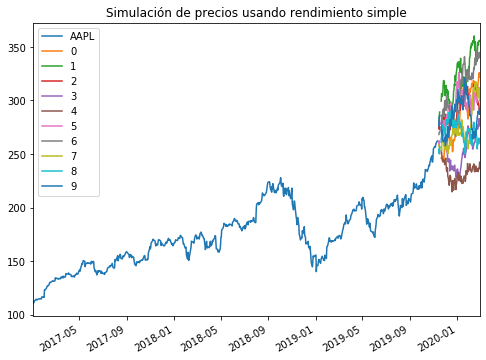

In [14]:
# Simulación del precio
S_0 = closes_aapl.iloc[-1,0]
S_T = S_0*(1+Ri_dt).cumprod()

# Se muestran los precios simulados con los precios descargados
pd.concat([closes_aapl,S_T]).plot(figsize=(8,6));
plt.title('Simulación de precios usando rendimiento simple');

In [16]:
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).iloc[1:]

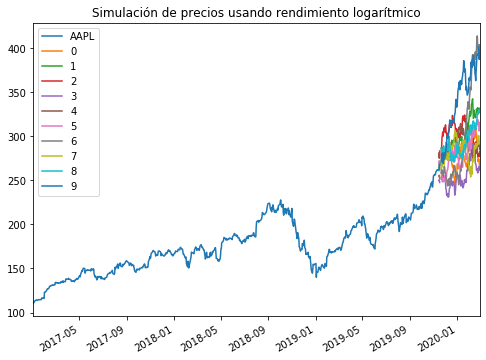

In [19]:
ri = calc_daily_ret(closes_aapl)
# Usando la media y desviación estándar de los rendimientos logarítmicos
mu_r = ri.mean()[0]
sigma_r = ri.std()[0]

# # Usando la equivalencia teórica
# mu_r2 = mu_R - (sigma_R**2)/2

sim_ret_ri = pd.DataFrame(mu_r*dt+Z*sigma_r*np.sqrt(dt), index=dates)

# Simulación del precio
S_0 = closes_aapl.iloc[-1,0]
S_T2 = S_0*np.exp(sim_ret_ri.cumsum())


# Se muestran los precios simulados con los precios descargados
pd.concat([closes_aapl,S_T2]).plot(figsize=(8,6));
plt.title('Simulación de precios usando rendimiento logarítmico');

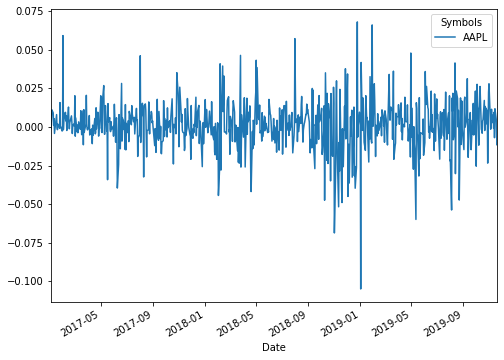

In [22]:
ret_aapl = calc_daily_ret(closes_aapl)
ret_aapl.plot(figsize=(8,6));

In [23]:
mu = ret_aapl.mean()[0]
sigma = ret_aapl.std()[0]
mu, sigma #Obtenemos la media y la desviación de los rendimientos

(0.0011838779914103003, 0.015724361041788027)

In [24]:
# Tasa de bonos de 1 yr de fecha 11/01/19 -> 1.53%
r = 0.0153/360 # Tasa diaria

In [26]:
from datetime import date
Hoy = date.today()
K=240  # strike price
ndays = 109 
nscen = 100000
dates = pd.date_range(start= Hoy, periods = ndays)
S0 = closes_aapl.iloc[-1,0]  # Condición inicial del precio a simular

sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())
#strike = pd.DataFrame({'Strike':K*np.ones(ndays)}, index=dates)
#simul = pd.concat([closes_aapl.T,strike.T,sim_closes.T]).T
#simul.plot(figsize=(8,6),legend=False);

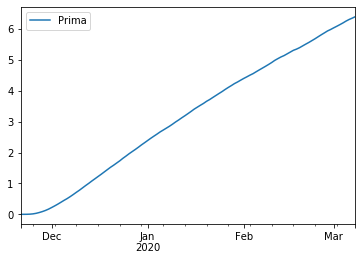

In [27]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]), index=dates)
put = pd.DataFrame({'Prima':np.exp(-r*ndays) \
              *np.fmax(strike-sim_closes,np.zeros([ndays,nscen])).T.mean()}, index=dates)
put.plot();

In [28]:
put.iloc[-1]

Prima    6.399
Name: 2020-03-08 00:00:00, dtype: float64

In [30]:
confianza = 0.99
sigma_est = sim_closes.iloc[-1].sem()
mean_est = put.iloc[-1].Prima
i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i1)
print(i1)

(6.040511361451895, 6.756935565766634)
(6.040511361451895, 6.756935565766634)
